In [1]:
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
sim.ResetKernel()

sim_len = 6000

Nlandmarks = 10

# srt_tm = 2000.
# stp_tm = 8000.

In [2]:
def plotSpks(ax,t,s): # define function to plot spikes in a common way
    ax.plot(t,s,'.')
    ax.set_ylabel('Neuron')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim([0,sim_len])

In [3]:
sim.SetDefaults("stdp_synapse",{"tau_plus": 15.0})

syn_dict = {"model": "stdp_synapse", "alpha": 0.5,"weight": 0.,'Wmax':105.,'delay': 1.}

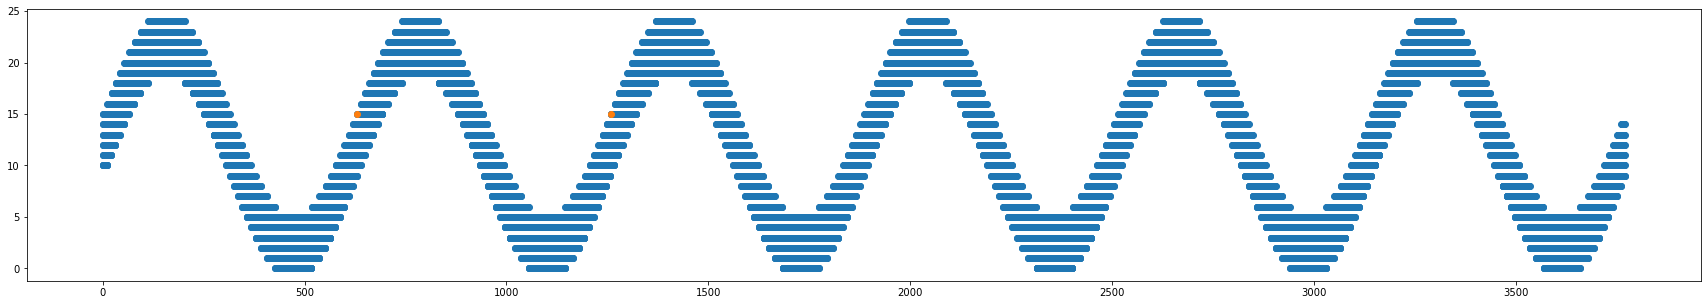

In [4]:
#make sinusoid of HD activity
diam = 6
sin = ((np.sin(np.arange(np.pi*1200)/100)+1)*10)//1
time = np.arange(1,len(sin)+1)*1.
orig_sin = sin
orig_time = time
temp = []
temptime=[]
for i in range(diam):
    temp = np.append(temp,sin+i)
    temptime = np.append(temptime,time)
sin = np.append(sin,temp)
time = np.append(time,temptime)

plt.figure(figsize=(30, 5))
plt.scatter(time,sin)

N = int(np.max(sin))

a = 630
plt.scatter([a,a*2],[15,15])

In [5]:
HD = sim.Create("iaf_psc_alpha",N)
g1 = sim.Create("iaf_psc_alpha",N)
view = sim.Create("iaf_psc_alpha",Nlandmarks, params={"tau_minus": 30.0})


In [6]:
params=[]
for i in range(N):
    idx = np.where(sin == i)
    spktms = time[idx]
    params.append({'spike_times':np.sort(spktms)})
    
HD_spikes = sim.Create('spike_generator', N, params)
sim.Connect(HD_spikes,HD,'one_to_one',syn_spec={'weight': 500, 'delay': 0.1})

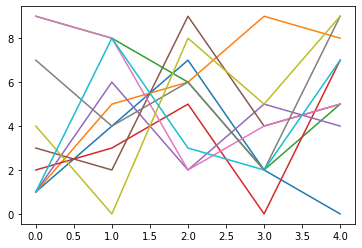

In [7]:
import random
patterns = []
for i in range(Nlandmarks):
    patterns.append(random.sample(range(0, Nlandmarks),5))
plt.plot(np.array(patterns).T)


In [8]:
# find 10 evenly distributed head directions
params2 = []
viewspikes = [[] for i in range(Nlandmarks)]
I_value = 300.
landmarkHDs = np.around(np.arange(0,2*np.pi,(2*np.pi)/Nlandmarks) * N/(2*np.pi))
for idx,landmark in enumerate(landmarkHDs):
    landmarktimes = np.sort(np.unique(orig_time[orig_sin == landmark]))
    landmarktimes = np.append(landmarktimes,landmarktimes+4000.)
#     print(landmarktimes)
#     print(patterns[idx])
    for cell in patterns[idx]:
        viewspikes[cell].extend(landmarktimes)

for v in range(Nlandmarks):        
    params2.append({'spike_times':np.sort(np.unique(viewspikes[v]))})

view_spikes = sim.Create('spike_generator', Nlandmarks, params2)
sim.Connect(view_spikes,view,'one_to_one',syn_spec={'weight': 300, 'delay': 0.1})

In [9]:
# sim.Connect(HD,g1, "one_to_one", syn_spec={'weight': 500, 'delay': 0.1})
sim.Connect(view,HD, "all_to_all", syn_dict)

In [10]:
HD_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
view_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})

sim.Connect(HD,HD_spikes)
sim.Connect(view,view_spikes)


In [11]:
sim.Simulate(sim_len)

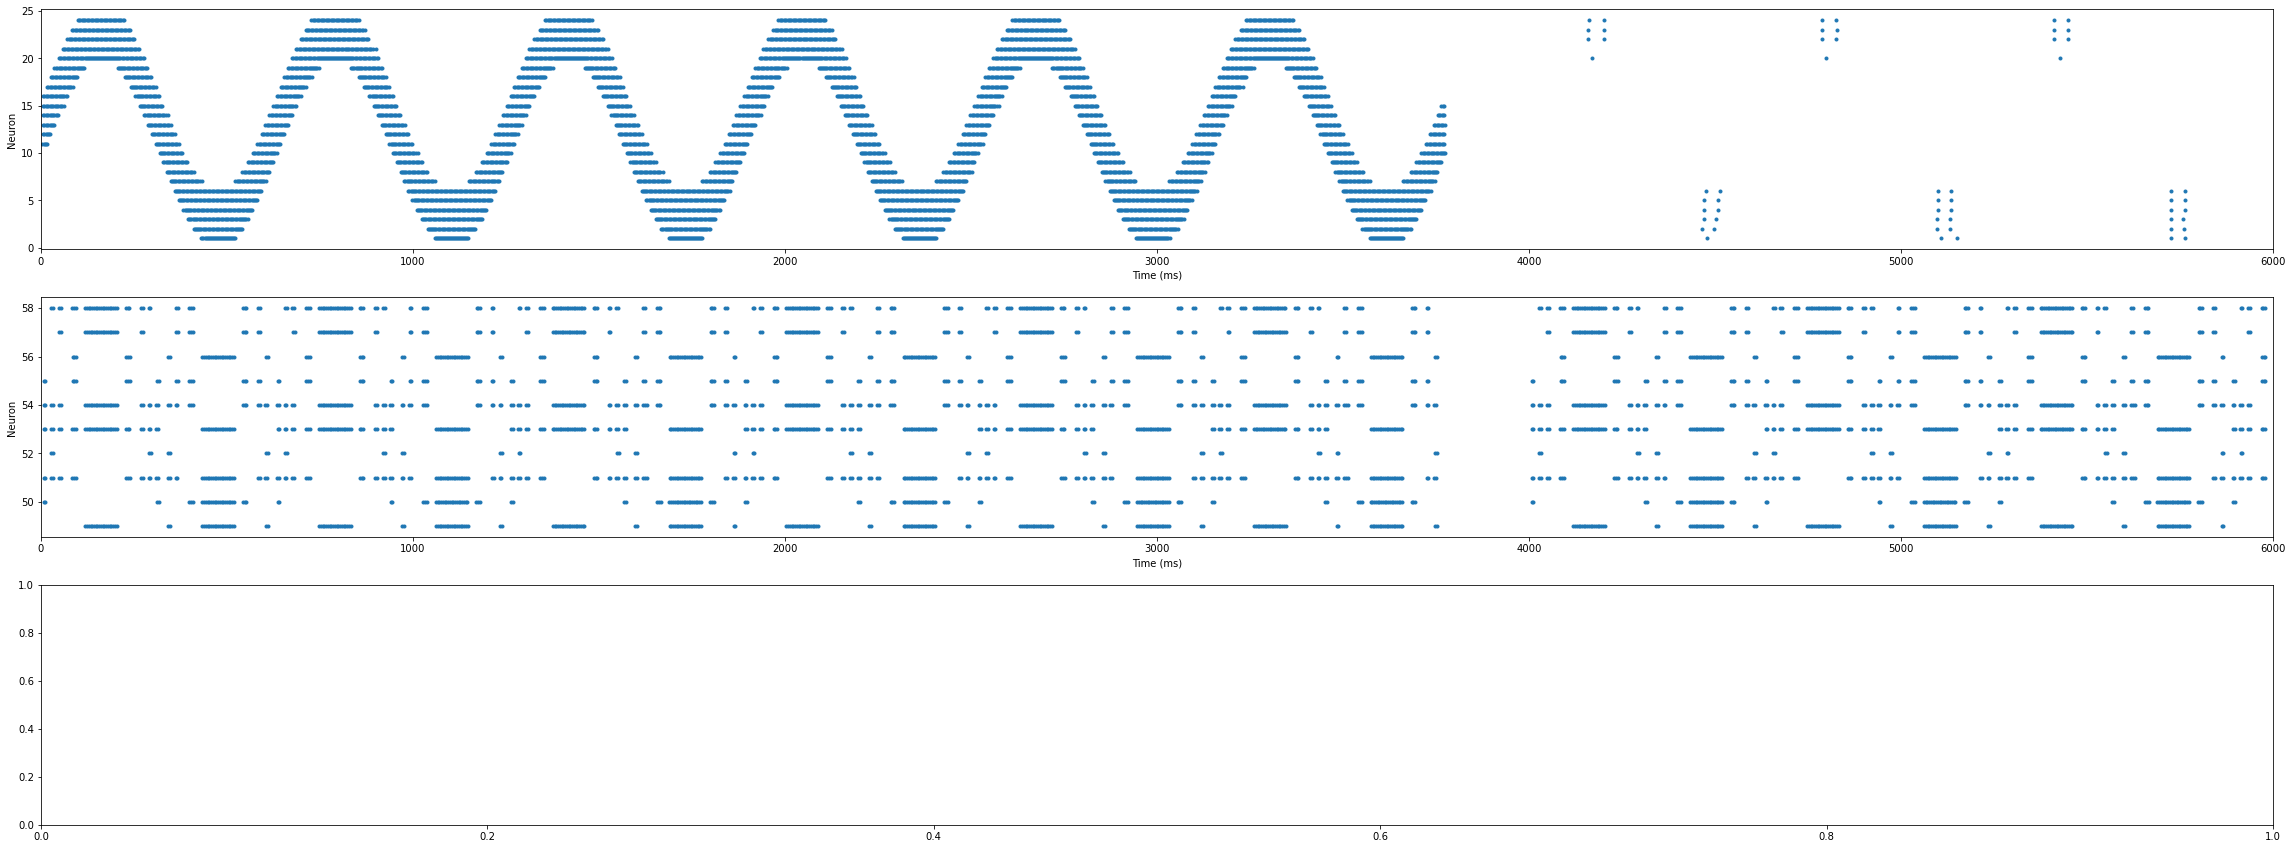

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(40, 15),facecolor='w')

ev = sim.GetStatus(HD_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax1,t,sp)

ev = sim.GetStatus(view_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax2,t,sp)